In [0]:
%matplotlib inline

# CSC420 Final Project
## Automatic License Plate Recognition

### By Peter Kungania and Mohamed Kazem


<div style='float:left'>
             <img src="https://www.gannett-cdn.com/-mm-/9cb09ba0f4b9447a42899d3907f30d4d75424bbe/c=0-274-3912-2484/local/-/media/2018/07/30/DetroitNews/DetroitNews/636685577407316973-Drone-01.jpg" alt="Police Drone With Camera" width='400px'/>
</div>
<div style='float:right'>
<img src="https://thephiladelphiapigeon.files.wordpress.com/2015/10/parking.jpg" alt="Drone in Philly Taking Photo of a Plate" width='400px'/>
</div>



## Introduction 


###Problem Motivation: 
Parking enforcement is currently highly inefficient and usually consists of an officer walking to different spots in the city and manually looking up the license plate of a vehicle to see if the user has paid. This is inefficient because it takes a long time and there are only so many officers patrolling the city. 

###Solution: 
We imagine a future where users will enter their license plates into an app (like GreenP) or a payment machine. Autonomous drones will then fly around the city, take shots of the license plate, and compare it against the database to see if the person has paid their due. This would be extremely cost and time effective. 

###What we have accomplished: 
For this assignment, we have gathered and labelled data, trained CNNs, and come up with our own algorithms. Given a photo of either the front or back of a car, our model can instance segment the license plate, process it, and then feed it character by character into an EMNIST-trained CNN for optical character recognition.



## Finding Data

Our first task was to find relevant data that we could use to train machine learning models on. 

We explored the possibility of using several different license plate datasets. We also considered finding our images and manually labelling the images ourselves. What we ended up doing was a combination of both. 

The dataset we used is a from a benchmark known as OpenALPR. It contains US license plates, which are similar in shape and style to Ontario’s.  The dataset can be found [here](https://github.com/openalpr/benchmarks/tree/master/endtoend).

One of the issues we had with the data was that in the labels, they had selected the entire plate from edge to edge. Many license plates also have other words around them such as the car dealership they purchased the car from. We did not want to train our models to capture those unnecessary words and so we opted to manually label the OpenALPR data ourselves using VIA Annotation tool. 

Here is an example of how we labelled an image:


In [0]:
import matplotlib.pyplot as plt
import skimage.io as io

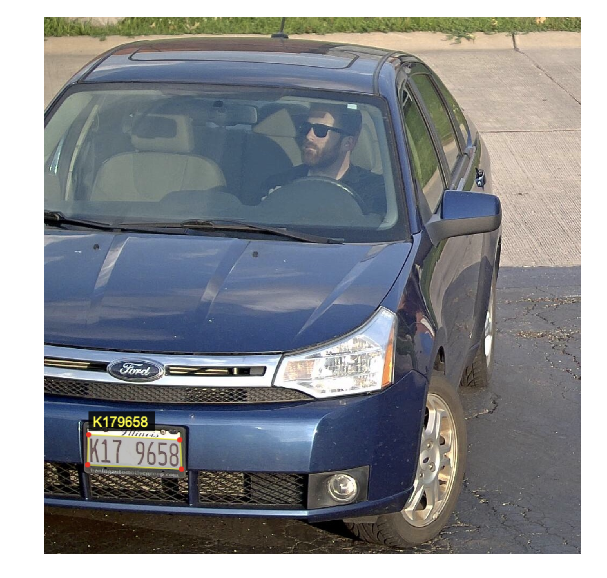

In [0]:
def showImage(filepath):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(io.imread(filepath))
    plt.axis("off")
    plt.show()
 
showImage("/content/labelledDatum.png")

The data consisted of 222 images of various resolutions (most are around 1024px x 1024px). 

Some of the images were quite large and had lots of "whitespace" around the vehicle and so we cropped images down in that case. 

After spending hours processing and labelling all of the images, we split the images into a 70/30  train/val split by random assignment. 

Now that we have our labelled data, we are ready to start training!

## Plate Detection

One of the more difficult sub-problems is: Given a photograph containing a car and its license plate, how can we detect the plate itself? 

### Algorithmic Approaches


There have been algorithmic approaches to locating license plates. Here is one such example from 2013: [ALPRS - A New Approach for License Plate Recognition using the Sift Algorithm
](https://arxiv.org/abs/1303.1667). This paper proposes using the SIFT algorithm to match images of license plate characters to a photo of a car with a license plate on it. However, we opted not to go with this approach as it isn't very robust - they acheived a hit rate of only 70%.If the license plate characters are in a font that doesn't match the templates, the success rate will likely be even worse.


It's also quite possible that it will have many false positives. 
For example, often on the side of police cars there are a few numbers identifying the police car #. This is different than the license plate and should not be detected. Finally, the authors stated that it took nearly 7 seconds to process a single image which is quite slow and is not real-time. 


That paper is from 2013, and we are currently in 2019 and it is the era of deep CNNs for object detection and segmentation tasks. With a moderately powerful GPU, even a deep CNN can be run in less than a second or two. Most importantly, CNNs have been shown to be quite robust and they perform very well on object detection tasks, which is why they became so popular. 






### Mask RCNN

One of the CNN architectures that was suggested to us by our TA Sayyed, is one that also came up quite often in our searches. This model is known as [Mask-RCNN](https://arxiv.org/abs/1703.06870). It is the successor to the well-known Faster-RCNN. We opted to go with Mask RCNN because it is high-performing model capable of instance segmentation. This means that it won't just place a bounding box around the plate, it will actually place a mask that determines exactly which pixels it thinks is the plate. As mentioned earlier, we want to focus on just the actual license plate characters and not the words around the plate (such as the dealership name) and so instance segmentation is ideal. 

#### Mask RCNN In a nutshell 
Mask RCNN extends the semantic segmentation capable Faster-RCNN by adding instance segmentation. While this is overkill for our purposes since it is highly unlikely to find two overlapping plates in an image, we opted to go with Mask RCNN because it is still very rapid. Another major plus is that there are well-documented implementations of it available online that we could use and learn from. 

The two high-level stages of Mask RCNN:


1.   **Region Proposal Network (RPN):** This creates around 200k boxes of various sizes and aspect ratios and locations across the entire image. But it isn't the original image that is used, but rather feature maps of the image that were produced as a result of running the original image through Resnet50. The RPN outputs two things for each bounding box: whether it believes the box be of the foreground or background class, and a refinement around the box in order to better encapsulate the object. The model only cares about the boxes in the foreground class. Among those, there may be many boxes with lots of overlap in a region and so it will use Non-maximal suppression to choose the box with the highest foreground score and it will discard the rest. 

2.  **Bounding Box Classification and Mask Generation**: now that we have all of these regions of interest (ROI), the model will run each box through a classifier to determine which object class it believes the object to be in. One of these classes is a "background" class, and if the box lands in that class, it will be discarded. In parallel to all of this, the model will generate masks for the detected objects.



As mentioned, Mask RCNN is essentially Faster RCNN but with one important new branch: a segmentation mask predictor that runs in parallel with the classification branches. This segmentation mask prediction runs on each Region of Interest (ROI) and it predicts which pixels belong to the object in the region, versus background pixels. This segmentation mask branch consists of a small Fully Convolutional Network. 


#### The Implementation we used

We used the implementation created by the fine folks at Matterport. Waleed Abdullah wrote an incredibly helpful piece about how he implemented a version of Mask RCNN that can [detect balloons](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46). It is this tutorial we followed, along with the code they provided in order to train the network. We adapted their code to work on our dataset and for this specfic task of license plate detection.

Once we had the data ready, we spent some time figuring out how to adapt this model to work on our task of license plate localization. 

The implementation supports using either Resnet50 or Resnet101 as the backbone feature map generator. There is a marginal improvement of about 1% of using Resnet101 over 50 but it would take much longer to train (because it has 51 more layers) and it would be slightly slower to infer from. We opted to go with Resnet50 in order for training time be reasonable.


#### Transfer Learning 
The authors of Mask RCNN said that training on the COCO dataset using a single machine with 8 GPUs takes 1-2 days. We do not have access to such a powerful machine. Luckily, others have been kind enough to share the weights that their models learned when training on COCO. 

The COCO dataset was selected a starting point for our transfer learning because it consists of many object classes, one of which is automobiles. The idea behind transfer learning is that if you train the model on one dataset, it will learn useful features in objects in general and so it can be quickly adapted to recognizing new objects (license plates) that it was not trained on prior. 

We used weights of a model pre-trained on COCO and so we were able to use transfer learning to quickly train the model on license plate segmentation. Another benefit of transfer learning, besides speed, is that relatively little data is needed for training. Our training set consisted of only 159 images, and our validation set had 63 images in it. This is a fairly small amount of data and it is unlikely that we could have acheived the accuracy we did had we trained the model from scratch. 

Training was done on a 2017 Macbook Pro and it took roughly 16 hours. This is because only the CPU was used. If we had access to a machine with a GPU, training would have taken roughly 1 hour instead. 

### Sample Input

Here's an example of what the input an the model looks like. Note that the model works best with images of size 1024\*1024 and so it will resize images and add black padding to get them into the desired size. 

Please note two things in this image: the bounding box around the plate, and the segmentation mask of the plate. 

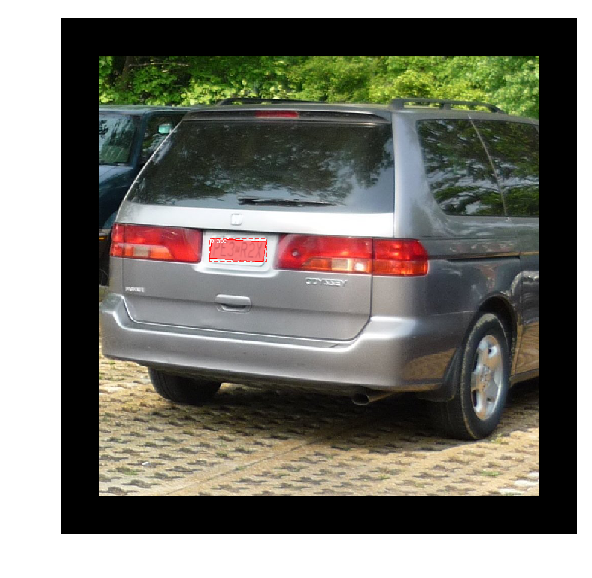

In [0]:
showImage("/content/plateBoxAndMask.png")

### Example of an Image with Regions (Anchors)

Please note that these are only a tiny fraction of the 200K + regions that the model actually generates. Note the different aspect ratios and sizes of the boxes, and how there is overlap between them.

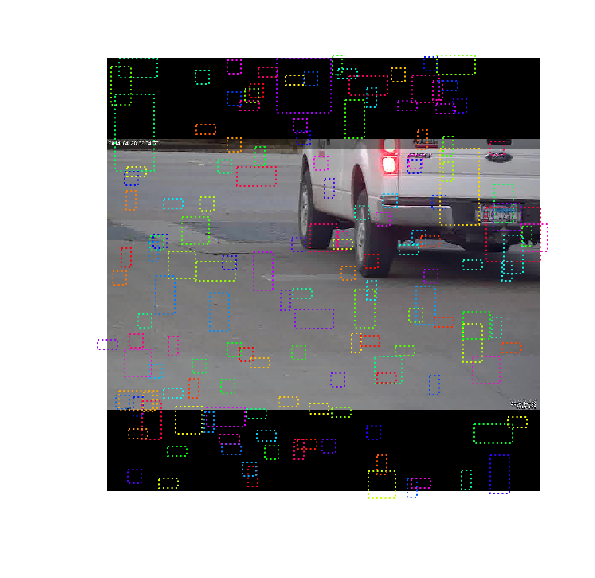

In [0]:
showImage("/content/regionBoxes.png")

### How well does the Mask RCNN model segment license plates on new images?

Quite well. Here are some examples:

It is able to detect more than just one plate at a time:

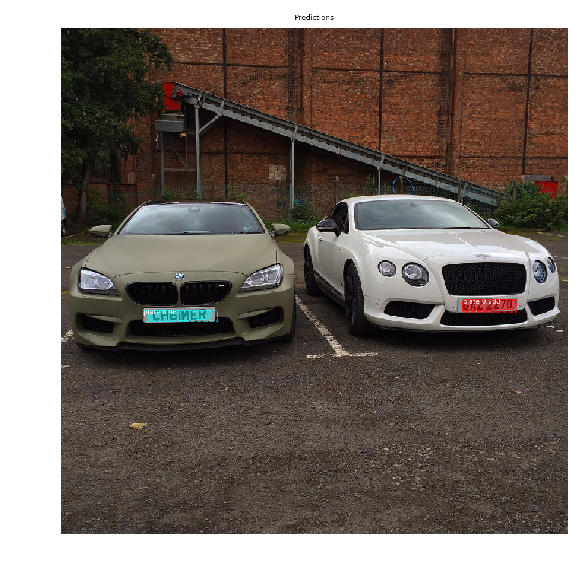

In [0]:
showImage("/content/testResultTwoCars.png")

Note: in the next example, it only detects the close license plate that is in focus. There is another plate further in the distance but the model doesn't pick it up. This is not an issue as in practice we would only want the closest plate detected. 

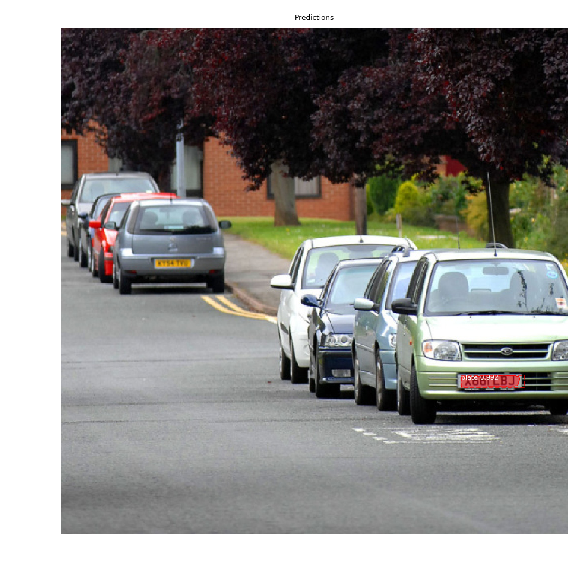

In [0]:
showImage("/content/detectsClosebyOnly.png")

### No Detection 
In the next example, the vehicle is so dirty that the model doesn't detect the plate. This model might not work so well in Canadian winters.

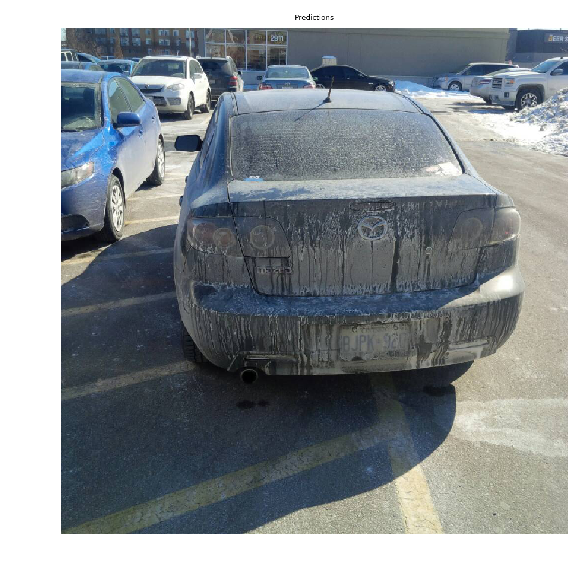

In [0]:
showImage("/content/dirtyCar.png")

It doesn't detect any and all characters on a vehicle, which is great. In the next example, the police car has the numbers "750-1" on the front-right panel and the model doesn't think it is a plate: 

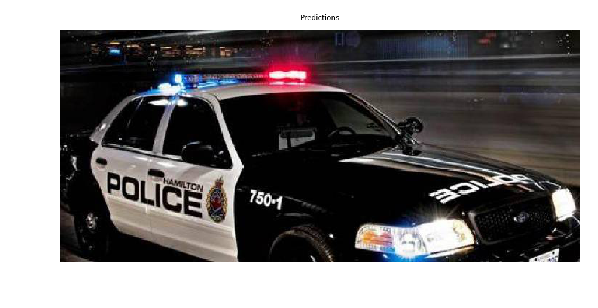

In [0]:
showImage("/content/policeCar.png")

### False Positive:

In the next example, our model inaccurately thought that the "King" in the Burger King logo is a license plate. This makes sense as the "KING" is all-caps and has a white background, similar to most license plates it was trained on. It was unable to detect the plates of the police cars, likely because they are too small.

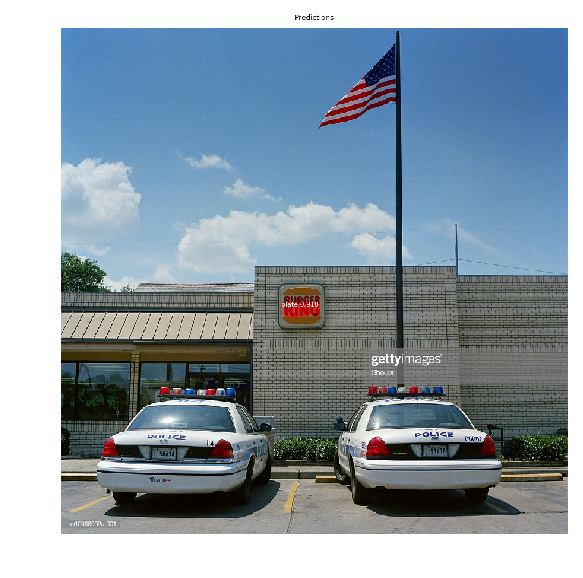

In [0]:
showImage("/content/FalsePositive.png")

### Mask too narrow
Sometimes the mask it generates is too narrow and truncates some of the characters. We believe the most likely explanation for this is because when we labelled our data we only selected the area around the letters and did not include the full license plate. If we were to do this again, we would train the model to recognize the entire license plate, from from edge to edge. To adjust for this, when we select the license plate we add a buffer of a few pixels in order to make sure we grab the as much of the letters as possible.

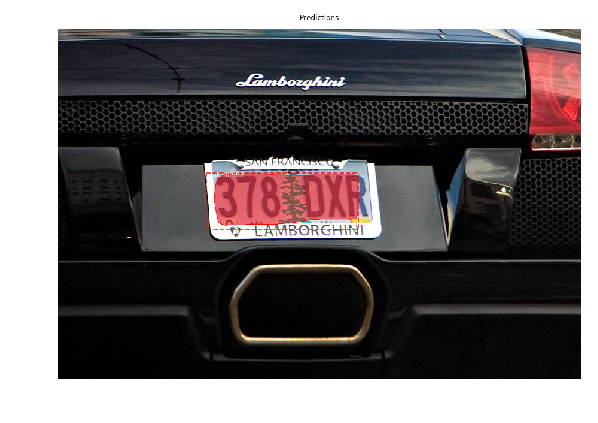

In [0]:
showImage("/content/lamborghini.png")

## Character Segmentation and Recognition

In most Automatic License-Plate Recognition (ALPR) software it is important to be able to properly distinguish between different characters since poorly segmented characters can lead to horrible predictions on the license plate number.

Prior to segmenting the different characters, we attempted to use Python-tesseract, which is an optical character recognition (OCR) tool for Python that will read text from images. The problem with it was that it was poor at properly detecting characters from noisy images. Since most of the images we are trying to read will come from the detected plates from the MaskRCNN model, then we expect for it to have a lot of noise. So we had to think of a better way to figure out the characters on the plate. 

This led us to opt for a different idea where we begin by segmenting each of the characters on the license plate and attempting to classify each character individually.

To begin this process we followed the processes described to us by the following paper, [Segmentation of Characters on Car License Plates](https://researchoutput.csu.edu.au/ws/portalfiles/portal/9621312/MM080325%5B1%5D.pdf). The problem that was encountered when applying these methods was that getting the gradient of the image resulted in more noise during the binarization process making it harder to distinguish between different characters. Even after applying a gaussian filter to the image there was still too much noise that made it hard to use the papers methods for segmentation.

That is when we found a new direction that did not require us to compute the gradients. Instead we just needed to extract the value component from the HSV colour space of the image. These new ideas were presented to us in the following webpage: [Segmenting characters from license plates](https://gurus.pyimagesearch.com/lesson-sample-segmenting-characters-from-license-plates/#).Here they also discuss binarizing the extracted value components and using contours to segment the characters. This is something that we will be doing as well.

## Character Segmentation of License Plates

### Imports

In [0]:
from collections import namedtuple
from skimage.filters import threshold_local
from skimage import segmentation
from skimage import measure
from skimage.transform import resize
from imutils import perspective
import imutils
import skimage.io as io
from skimage import filters

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Binarization Function

Before we can begin to segment the characters on the license plate from one another, we need to first begin by properly distinging between the characters on the license plate and it's background.

To do this we apply the following steps:
* Extract the value component from the HSV color scheme and keep it as a new image
* Reduce noise by applying a gaussian filter to the new image to smooth the image and so that the connected components are not broken up
* Binarize that smoothed image with Otsu thresholding in order to give a clearer distinction between the characters on the license plate and its background


**Why Extract the Value Component?**

By doing this we are able to have a better chance at extracting the dark regions (the characters) from the lighter region which would be the actual license plate. This is due to the fact that every pixel in the Value component is made up of the maximum between the three colour channels of RGB. So essentially this would provide us with information about the brightness of the plate which will be useful as most plates will have the darker regions being on the characters themselves.

**Why Otsu Thresholding?**

Although we could have used adaptive thresholding to account for variation in illumination for different parts of the image as done in the example on the webpage, we opted for Otsu binarization instead as it provided better results when trying to get a threshold that helps distinguish the characters from their background.

We believe that this is because Otsu thresholding selects a threshold between two peaks making it better for segmenting the characters from their background. In this case one of the peaks would be the intesity values of the characters form the Value component and another being the intensity values of the background. By applying Otsu we were able to clearly binarize to see the characters on the image.

In [0]:
def binarize(image):
    """
    This function takes an image of a license plate 
    and it returns a binarized image of the plate
    
    image: Grayscale image, smoothed image
    """
    # Extracting the Value from the HSV colour space of the image
    value_hsv = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))[2]
    plt.title("Value Component from HSV Color Space")
    plt.imshow(value_hsv, cmap="gray")
    plt.show()
    
    # Applying Otsu's thresholding to the Image
    smooth_hsv = cv2.GaussianBlur(value_hsv,(5,5),0)
    ret,th = cv2.threshold(smooth_hsv,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # remove any rows that consist entirely of 255s because those are just the plate border
    th = th[np.any(th != 0, axis=1)] 
    
    return th

### Character Segmentation Helper (Contours)

This following code is taken from the *detectCharacterCandidates* function that is found in the following webpage: [Segmenting characters from license plates](https://gurus.pyimagesearch.com/lesson-sample-segmenting-characters-from-license-plates/#). It returns a list of character images from  a binarized image.

It begins by getting a list of all the possible characters by returning a list of all the connected components. For each of those connected components we need to check if they contain any contours. If there are any contours in the image then we need to apply the following steps:

* Select the biggest contour in the compnent
*	Compute the different ratios that willl be used to determing is the contour's bounding box contains a character. These ratios are the:

> * aspect ratio: width over height
> * height ratio: contour height over plate height
> * solidity ratio: contour area over the convex hull area

*	Applying a threshold value for each of the ratios that will be used to determine if the selected contour contains a character
*	If the contour does contain a character (i.e. it passed all ratio tests) then we add it to the list of character images.


In [0]:
def char_seg(thresh):
    """
    Return the segmented characters
    """    
    character_images_list = []

    # perform a connected components analysis and initialize the mask to store the locations
    # of the character candidates    
    labels = measure.label(thresh, neighbors=8, background=0)
    charCandidates = np.zeros(thresh.shape, dtype="uint8")
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue

        # otherwise, construct the label mask to display only connected components for the
        # current label, then find contours in the label mask
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if imutils.is_cv2() else cnts[1]
        
        # ensure at least one contour was found in the mask
        if len(cnts) > 0:
            # grab the largest contour which corresponds to the component in the mask, then
            # grab the bounding box for the contour
            c = max(cnts, key=cv2.contourArea)
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)

            # compute the aspect ratio, solidity, and height ratio for the component
            aspectRatio = boxW / float(boxH)
            solidity = cv2.contourArea(c) / float(boxW * boxH)
            heightRatio = boxH / float(thresh.shape[0])

            # determine if the aspect ratio, solidity, and height of the contour pass
            # the rules tests
            keepAspectRatio = aspectRatio < 1.0
            keepSolidity = solidity > 0.15
            keepHeight = heightRatio > 0.4 and heightRatio < 0.95

            # check to see if the component passes all the tests
            if keepAspectRatio and keepSolidity and keepHeight:
                # compute the convex hull of the contour and draw it on the character
                # candidates mask
                hull = cv2.convexHull(c)
                cv2.drawContours(charCandidates, [hull], -1, 255, -1)
                
#                 plt.imshow(labelMask, cmap='Greys_r')
                character_images_list.append(labelMask)
  
  
    return character_images_list

### Transform Characters Helper

With the list of segmented characters we need to change the characters into a format that we can use for classification with our trained convolutional neural network. So we sort them and crop them into return an ordered list of $28\times28$ sized images similar to that in the EMNIST dataset.

In [0]:
def sortAndCropCharacters(characterLst, resizeShape=(28,28)):
  '''
  Sorts the characters from left-to-right positions and crops each of them
  Returns a sorted list of cropped, resized character images
  '''
  
  # Some of the cropping code is from here: https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy
  # Mask of non-black pixels (assuming image has a single channel).
  resultingImagesList = []
  
  for image in characterLst:
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    padding = 7 # include this many pixels of white space around the character
    
    x0, y0 = max(0, x0 - padding), max(0, y0 - padding)
    x1, y1 = coords.max(axis=0)
    x1, y1 = min(image.shape[0], x1 + padding), min(image.shape[1], y1 + padding)

    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]

    #resize to 20*20 pixels then will add padding to get it up to 28*28
    resizedImg = resize(cropped, (20, 20), mode='constant', anti_aliasing=True)
    # So that char will have more white space around it, like EMNIST data
    resizedImg = np.pad(resizedImg, ((4,4), (4,4)), 'constant')
    
    resultingImagesList.append((y0, resizedImg)) 
    
  
  # Sort characters by order they appear in (Left-to-right) using leftmost pixel, x0
  resultingImagesList = sorted(resultingImagesList, key=lambda x:x[0])

  return [i[1] for i in resultingImagesList] # only return images, not leftmost pixel locations

In [0]:
# Displays a list of character images to screen in one figure
def displayCharacterImgs(characterImgs):
  plt.figure(figsize=(3, 3))
#   plt.figure()
  for i in range(len(characterImgs)):
    plt.subplot(1, len(characterImgs), i+1)
    plt.axis('off')
    plt.imshow(characterImgs[i], cmap='Greys_r')

    plt.show()

### Segmentation Function

In [0]:
def segmentation(img):
  """
  img: image of a license plate
  This function returns a segmentation of
  the selected licence plate
  return: a list of character images
  """
  # Get a binarized image with only the characters
  binarized_image = binarize(img)

  plt.figure()
  plt.title("Binarized Image")
  plt.imshow(binarized_image, cmap="gray")
  plt.show()
  # Flip greyscale (black becomes white, white becomes black)
  # Then run it through character segmentation function
  characters = char_seg(np.abs(binarized_image-255))

  # Will sort characters in left-to-right order and return the images with less whitespace around them
  characters = sortAndCropCharacters(characters)

  return characters

## Character Recognition -- Using EMNIST Dataset

Now that we have segmented our characters, we are left with a new problem. We need to be able to classify each of the characters.

The solution that we thought of was to implement a Convolutional Neural Network as it would be the best way for us to recognise each of those characters. However this led to more problems as we were unable to find an available dataset that was best fitted for classifying our segmented license plate characters.

So inorder to tackle this new problem of character recognition we decided to use the EMNIST dataset to train our convolutional neural network. This dataset is an extension of the MNIST dataset and it includes a collection of handwritten letters and digits. 

The reason for chosing this dataset was that it contained a large number variations for all characters. And also from the segmented characters we could transform each character so that it can be of similar format found the EMNIST dataset which would allow us to better classify our dataset using a model that was trained on the EMNIST dataset.

We utilitzed the following resource when implementing our own convolutional neural network: [TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

**Reference for dataset:**

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

### Import

In [0]:
# !pip install -q torch==1.0.0 torchvision

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Running on GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


### Getting the Data

In [0]:
transform = transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.EMNIST(root='./training.pt', train=True, 
                          split='balanced', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True,
                                          num_workers=2)
testset = datasets.EMNIST(root='./test.pt', train=False, 
                         split='balanced', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, 
                                         num_workers=2)

In [0]:
classes = ['0','1','2','3','4','5','6','7','8','9',
           'A','B','C','D','E','F','G','H','I','J','K',
           'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
           'a','b','d','e','f','g','h','n','q','r','t']

### Checking Data Import

g
(3, 392, 242)


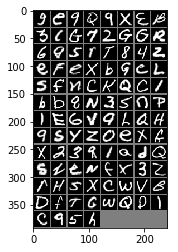

    g     e     9     Q


In [0]:
def show(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random test images
dataiter = iter(testloader)
images, labels = dataiter.next()

plt.show()
print(classes[labels[0]])

# show images
show(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### Neural Network Architecture for EMNIST Character Classification

Below is a simple convolutional neural network architecture that contatins:

* One convolutional layer with ReLU activation
* One max pooling layer
* A dropout out layer with 0.2 probability. Used to avoid overfitting
* Two fully connected layers for the classification

This architecture was modeled based on the architecture in the following Kaggle notebook: [cnn_emnist](https://www.kaggle.com/hardiksaraiya/cnn-emnist/notebook)

We avoided creating a more complex architecture since we could end up overfitting on the EMNIST dataset which would make our model useless for predicting our segmented license plate characters.

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.pool = nn.MaxPool2d((2, 2))
    self.conv2_drop = nn.Dropout2d(p=0.2)
    self.fc1 = nn.Linear(32*13*13, 512) 
    self.fc2 = nn.Linear(512, 47)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.dropout(x, training=self.training)
    x = x.view(-1,32*13*13)
    x = F.relu(self.fc1(x))
    x = F.log_softmax(F.relu(self.fc2(x)), dim=1)
    return x

### Accuracy of the Network on the EMNIST Dataset

In [0]:
def printTestAccuracy():
  '''Evaluates and prints out how well the module is doing on the test set'''
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

In [0]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.2)
  (fc1): Linear(in_features=5408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=47, bias=True)
)

### Training the Convolutional Neural Network on EMNIST Dataset

After training our model with various learning rates and epoch numbers we decided to stick to a 0.01 learning rate and 10 epochs since changing it did not result in any significant differences in the training loss or significant changes in the accuracy on the test images.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch # ", epoch)
    running_loss = 0.0
    for i, (data, target) in enumerate(trainloader):
        # get the inputs
        inputs, labels = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
            
            printTestAccuracy()
            
print('Finished Training')

# Save weights
weightsFilePath = '/EMNIST_classifier_weights'
torch.save(net.state_dict(), weightsFilePath)

Epoch #  0
[1,  1000] loss: 1.400
Accuracy of the network on the 10000 test images: 76 %
Epoch #  1
[2,  1000] loss: 0.592
Accuracy of the network on the 10000 test images: 82 %
Epoch #  2
[3,  1000] loss: 0.462
Accuracy of the network on the 10000 test images: 83 %
Epoch #  3
[4,  1000] loss: 0.411
Accuracy of the network on the 10000 test images: 84 %
Epoch #  4
[5,  1000] loss: 0.379
Accuracy of the network on the 10000 test images: 84 %
Epoch #  5
[6,  1000] loss: 0.356
Accuracy of the network on the 10000 test images: 84 %
Epoch #  6
[7,  1000] loss: 0.335
Accuracy of the network on the 10000 test images: 85 %
Epoch #  7
[8,  1000] loss: 0.320
Accuracy of the network on the 10000 test images: 85 %
Epoch #  8
[9,  1000] loss: 0.301
Accuracy of the network on the 10000 test images: 85 %
Epoch #  9
[10,  1000] loss: 0.289
Accuracy of the network on the 10000 test images: 85 %
Finished Training


### Restoring the Training Weights

In [0]:
#Later to restore:
weightsFilePath = "/content/EMNIST_classifier_weights"
net.load_state_dict(torch.load(weightsFilePath))
net.eval()

In [0]:
def segmentPlateAndDisplay(filename):
  '''
  Given a path to an image file containing a license plate,
    this will run it through the segmentation code and display the output at each step
    It will also run each character through the EMNIST classifer and output the predictions
  '''
  plt.figure()
#   plt.figure(figsize=(5,4))
  plate = plt.imread(filename, cv2.CV_16UC1)
  plt.imshow(plate)
  plt.show()

  characters = segmentation(plate)

  with torch.no_grad():
    for charImg in characters: 
      plt.figure(figsize=(2, 2))
      plt.imshow(charImg, cmap='Greys_r')
      plt.axis("off")
      plt.show()
      outputs = net(torch.FloatTensor([[charImg]]).to(device))
      _, predicted = torch.max(outputs, 1)

      print('Predicted: %5s' % classes[predicted[0]])
    

### Example of performance on a photo of a license plate obtained from the internet

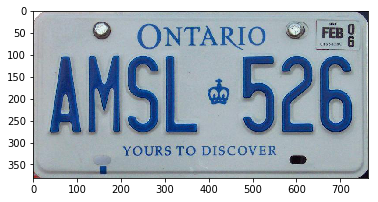

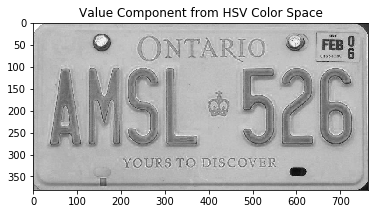

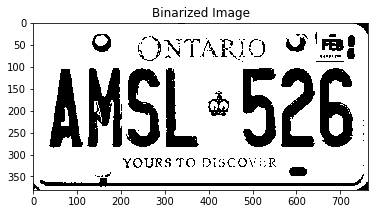

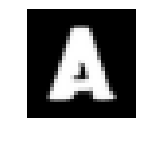

Predicted:     a


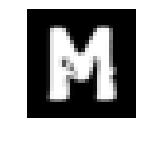

Predicted:     M


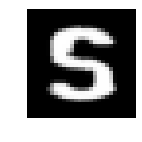

Predicted:     S


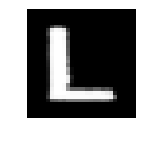

Predicted:     K


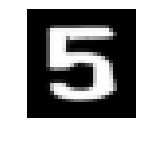

Predicted:     5


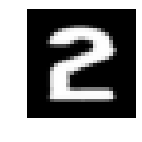

Predicted:     R


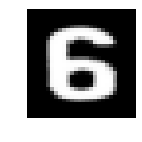

Predicted:     B


In [0]:
segmentPlateAndDisplay('/content/plate_only2.jpg')

## Performance on output of our Mask RCNN model:

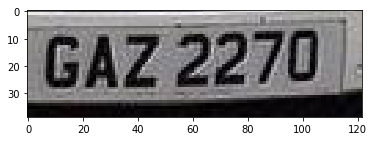

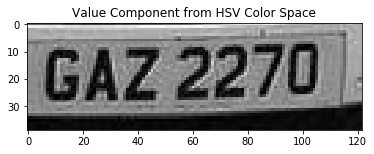

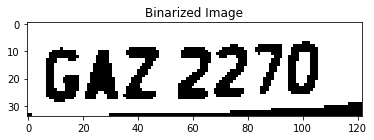

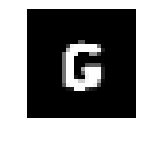

Predicted:     B


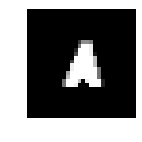

Predicted:     q


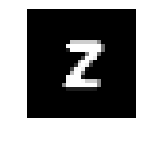

Predicted:     q


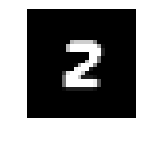

Predicted:     g


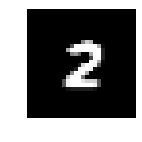

Predicted:     a


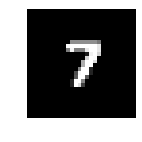

Predicted:     q


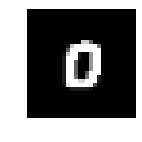

Predicted:     A


In [0]:
segmentPlateAndDisplay('/content/test3_plate.jpg')

## Future Improvements 

In the future, if we would like to improve the performance of this system, we would retrain model using entire license plate. This should improve the masks and bounding boxes that the model outputs so that it will no longer truncate characters. We would also use Resnet101 as the backbone feature map generator instead of Resnet50. The added depth of Resnet101 might result in fewer false positives and misses. Another thing we could do is train Mask RCNN on more examples. By adding more labelled data, it may better segment the plates.

We would also opt to perform transfer learning on the EMNIST classifier with our own labelled data to see if we can boost character recognition performance that way. Character recognition is current not great, and we think this may be because the characters we generate do not look like EMNIST characters (ours are thicker and have more noise). 


## Contributions

Mohamed Kazem: 

1.  Gathering Data, processing it, labelling and annotating it.
2.  Training MaskRCNN to locate license plates
3.  Processing MaskRCNN output (sorting and cropping characters, experimenting with filters to improve performance)

Peter Kungania:


1. Binarized the plate images to seperate characters from the background and using contours to segment the different characters prior to Mohamed's sorting and cropping. 
2. Implementing and training a convolutional neural network on the EMNIST dataset that can be used to classify the segmented plate characters



